# Bayesian Regression

Packages:
- pymc3
- pyflux


## Regression Formula
$$y_{t} = \beta_0 + \sum_{i=1}^{t}(\beta_{t-i}y_{t-i} + \epsilon_i) +  \sum_{i=1}^{N}\beta_j x_{ji}$$ 


Inputs:
- historical abatement
- gdp (2014)
- gdp (try lags)
- patents

In [1]:
import numpy as np
import pandas as pd

import pyflux as py
from pymc3 import Model, Normal, HalfNormal

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
xi = pd.read_csv('./Data/abatement_calculations.csv')
xi.set_index('country', inplace=True)
xi.drop('Unnamed: 0', axis=1, inplace=True)

target = xi['2014']

In [3]:
gdp = pd.read_excel('./Data/gdp_pc.xlsx')

In [4]:
Countries = ['Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal','Romania',
'Spain','United Kingdom','Turkey','Sweden','Norway','Kazakhstan','Ukraine','Uzbekistan','Canada',
'United States','Argentina','Brazil','Chile','Colombia','Mexico','China','India','Indonesia',
'Japan','Malaysia','Thailand','Australia','New Zealand','Algeria','Nigeria','South Africa','Kuwait',
'Saudi Arabia','United Arab Emirates','World'
    ]

gdp = gdp.loc[gdp['Country Name'].isin(Countries)].sort_values('Country Name')
gdp.set_index('Country Name', inplace=True)

In [5]:
xi['gdp_2014'] = gdp[2014]

In [15]:
us = xi.loc['Norway']

In [16]:
target['Norway']

573.354573913045

In [17]:
# X=inputs formatted as a matri

In [18]:
print(f'range: {target.min(), target.max()} \nvariance: {target.var()}\
      \nstandard deviation: {np.std(target)}')

range: (0.0, 4539.385507525213) 
variance: 575879.7811914817      
standard deviation: 748.815765130179


In [19]:
np.var(target)

560725.0501074954

In [104]:
print(f'range: {y.min(), y.max()} \nvariance: {y.var()}\
      \nstandard deviation: {np.std(y)}')

range: (-0.30450917633349056, 5.757576745076107) 
variance: 1.0000000000000002      
standard deviation: 1.0


In [105]:
from pymc3 import find_MAP
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot

In [125]:
y = np.array(target)
X = np.array(xi)

In [127]:
from sklearn.preprocessing import StandardScaler
ss_y = StandardScaler()
y = ss_y.fit_transform(y.reshape(-1,1))

In [122]:
y.shape

(38, 1)

In [113]:
ss = StandardScaler()
X = ss.fit_transform(X)

1. change standard scalers to be unique
2. use inverse_transform to convert predictions
3. 

In [114]:
basic_model = Model()
with basic_model:
    # start by defining distribution for all parameters
    # use sd to determine strength of the prior
    # big sd is a weak prior
    intercept = Normal('intercept', mu=0, sd=6)
    # the shape on beta is the number of features in the fit
    beta = Normal('beta', mu=0, sd=6, shape=26)
    # sigma is the width of the gaussian around yhat
    # (i.e. related to the size of the residuals)
    sigma = HalfNormal('sigma', sd=1)

    # create a formula for yhat
    y_hat = intercept + beta * X

    # simulate data as a distribution around yhat
    Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

In [69]:
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

logp = -1,131.8, ||grad|| = 42.3: 100%|██████████| 17/17 [00:00<00:00, 1362.18it/s]  

{'intercept': array(3.36379336e-13), 'beta': array([ 0.57003637,  0.57714112,  0.41862853,  0.4310791 ,  0.61031362,
        0.65141598,  0.80841095,  0.69698675,  0.62961802,  0.6531111 ,
        0.61307002,  0.77952721,  0.74748897,  0.83814355,  0.8746007 ,
        0.8373047 ,  0.89509293,  0.93630267,  0.88543402,  0.99510178,
        0.99778008,  0.99668008,  0.99891619,  0.99967369,  0.99999996,
       -0.06900884]), 'sigma_log__': array(-0.47455975), 'sigma': array(0.6221589)}


In [70]:
with basic_model:
    trace = sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 20500/20500 [00:36<00:00, 562.91it/s]


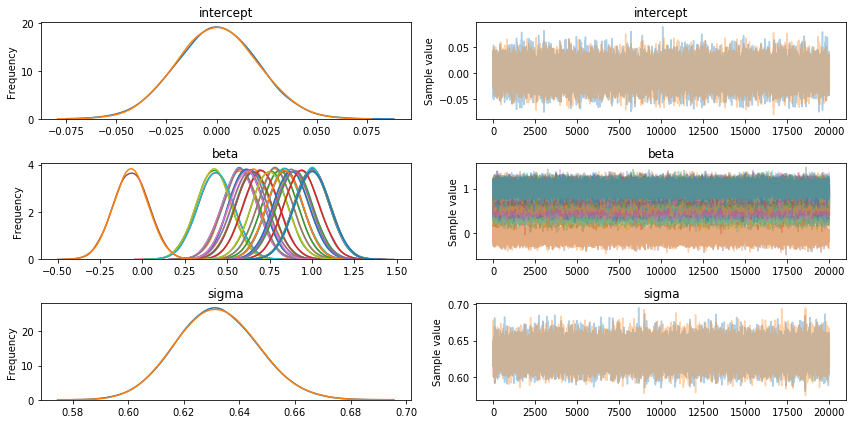

In [72]:
#look into breaking this stuff apart for better analysis

traceplot(trace);

In [84]:
#

beta_0_mean = np.mean(trace['intercept'])
beta_1_mean = np.mean(trace['beta'],axis=0)

# x = apm_age.Age.values
# y = apm_age.APM.values

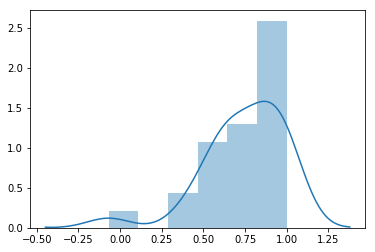

In [87]:
sns.distplot(beta_1_mean);

In [129]:
y_hat = beta_0_mean + np.matmul( X, beta_1_mean)

In [130]:
y_hat.shape

(38,)

In [131]:
y.shape

(38, 1)

In [135]:
y = ss_y.inverse_transform(y)
y_hat = ss_y.inverse_transform(y_hat.reshape(-1,1))

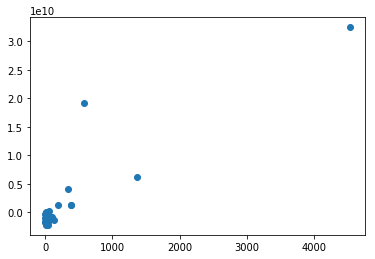

In [137]:
plt.scatter(y,y_hat);

- build a dataframe where features are lagged timepoints
- target is the next feature in the progression  
  
- specify priors on all coefficients
- specify priors on variance of data
- plug things into the model 
- follow pymc3 lesson

- goal is actually a posterior predictive
- pyflux provides uncertainty bounds (UL + LL)
- for a highly generalized bayesian regression try pymc3
    - you  need to specify priors and distributions
    - begin with something relatively uninformative (broad gaussian, uniform, etc.) 


- specify priors for each coefficient, prior on variance. Pick a prior that doesn't have sharp boundaries
    - you can start with normal because that aligns with the assumptions of a regular linear regression model
    - a large standard deviation will create a weak prior (begin with this)
    - in order to determine the starting size, scale the data and look at the size of the target (if you scale your inputs you know the beta size will be more strongly reflective of the size/range of your target)
    - note the distributions
    
## $$\beta_0 \sim Uniform(-200, 200)$$

## $$\beta_1 \sim Uniform(-10000, 10000)$$

## $$\epsilon \sim Uniform(0.0001, 1000)$$

- take existing objects/variables that contain priors and build a likelihood distribution with observed data
    - prior variables act as parameters
    - MCMC
    - pyMC3 does this using log likelihood

- estimate y-hat and save values
    - this is where we capture variance
  
- write out a function to pull samples from these distributions
    - codify the samples pulled, **construct a distribution of y-hat** fitting to obtain bounds and represent uncertainty or anticipated variance
        - we can use this to set a confidence interval
    - combining these observations to understand uncertainty is where this gets shaky
    $X \sim N(\mu,\sigma)$